SAM-3
=====
**SAM-3: Segment Anything with Concept"


 * Paper: https://scontent-sjc6-1.xx.fbcdn.net/v/t39.2365-6/585895112_1502482260871702_2839727966936571770_n.pdf?_nc_cat=108&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=dcPGs8T4dAsQ7kNvwGRiDLW&_nc_oc=AdnvInlvJ_PBP7Cp_Z8IaCL30Uesp_bbiW49f1eO3KuR72B7PlCZdeJQQW-xLFUOhaE&_nc_zt=14&_nc_ht=scontent-sjc6-1.xx&_nc_gid=QBgsAPfG3EiEl0XCoB3RQg&oh=00_Afizuq7MnomB8IyW1nPYCBXNfO4OImXmESvODrus0Zj4JQ&oe=692726ED


 ![SAM3 Overview](../assets/sam3_overview.jpg)

 ![SAM3 Data Engine](../assets/sam3_data_engine.jpg)

## Installation

```bash
conda create -n sam3 python=3.12 -y
conda activate sam3

# install torch
pip install torch==2.7.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

git clone https://github.com/facebookresearch/sam3.git SAM3_repo
cd SAM3_repo
pip install -e .

pip install einops decord pycocotools

pip install matplotlib
```

## Inference 1

In [8]:
import torch
from PIL import Image, ImageDraw
from sam3.model_builder import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
import matplotlib.pyplot as plt


In [3]:
# Load the model (using the build method)
model = build_sam3_image_model()
processor = Sam3Processor(model)

Found 2 masks for prompt: plants


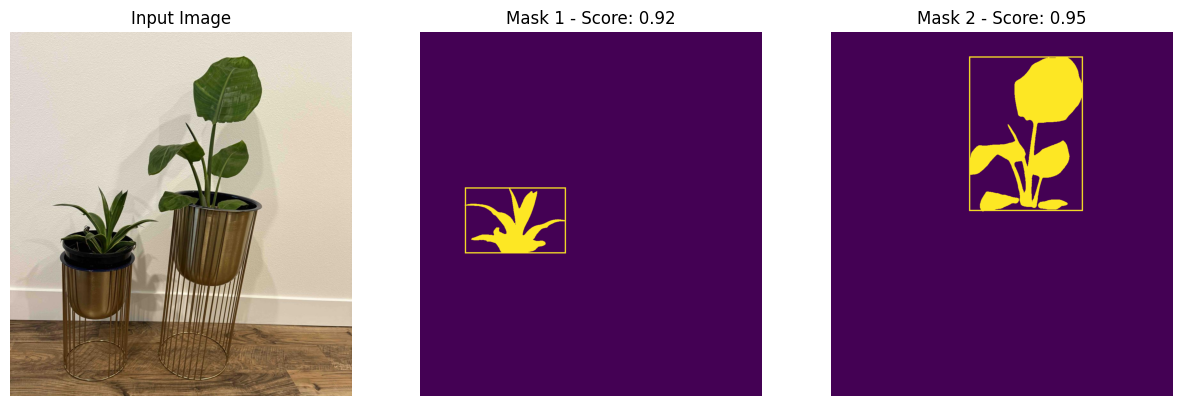

In [13]:
#################################### Inference on Image ####################################

image_path = "../samples/plants.jpg"
prompt = "plants"

# Load an image
image = Image.open(image_path)
inference_state = processor.set_image(image)
# Prompt the model with text
output = processor.set_text_prompt(state=inference_state, prompt=prompt)

# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]
print(f"Found {len(masks)} masks for prompt: {prompt}")

fig, axes = plt.subplots(1, len(masks) + 1, figsize=(len(masks) * 5 + 5, 5))
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[0].axis("off")
for i, mask in enumerate(masks):
    mask = Image.fromarray((mask.cpu().numpy()[0] * 255).astype("uint8"))
    # draw bounding box on mask
    draw = ImageDraw.Draw(mask)
    draw.rectangle(boxes[i].cpu().numpy().tolist(), outline="white", width=4)

    
    axes[i + 1].imshow(mask)
    axes[i + 1].set_title(f"Mask {i + 1} - Score: {scores[i]:.2f}")
    axes[i + 1].axis("off")
plt.show()

Found 4 masks for prompt: raised planter / vase


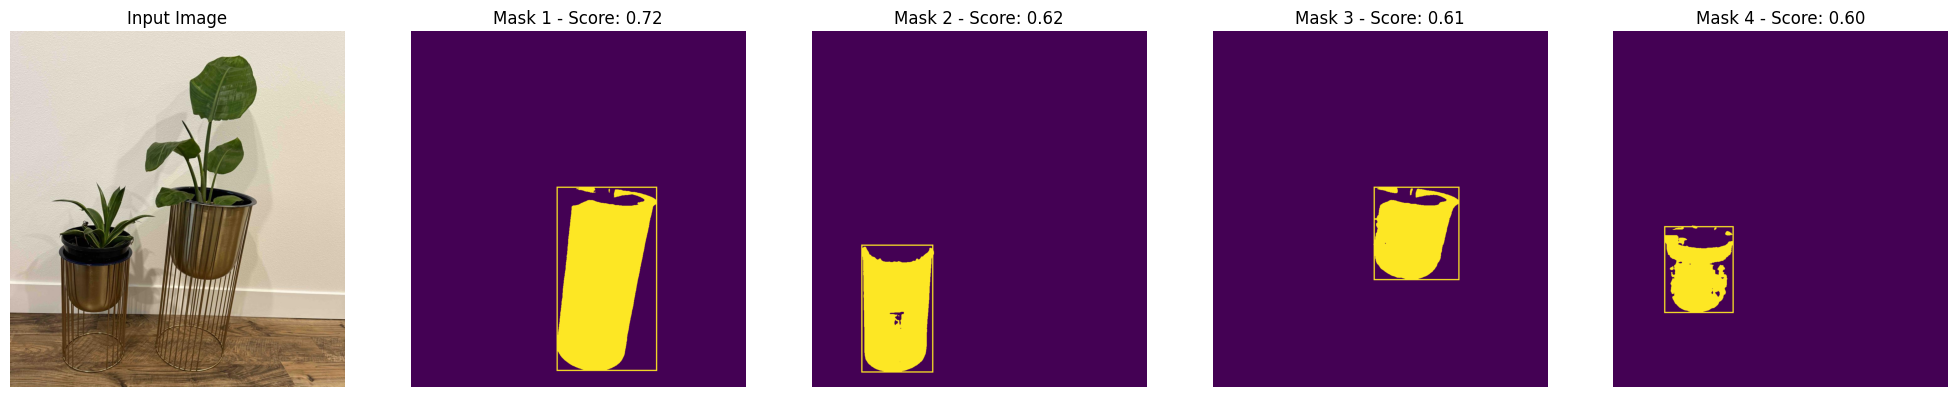

In [ ]:
#################################### Inference on Image ####################################


prompt = "raised planter / vase"

# Load an image
image = Image.open(image_path)
inference_state = processor.set_image(image)
# Prompt the model with text
output = processor.set_text_prompt(state=inference_state, prompt=prompt)

# Get the masks, bounding boxes, and scores
masks, boxes, scores = output["masks"], output["boxes"], output["scores"]
print(f"Found {len(masks)} masks for prompt: {prompt}")

fig, axes = plt.subplots(1, len(masks) + 1, figsize=(len(masks) * 5 + 5, 5))
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[0].axis("off")
for i, mask in enumerate(masks):
    mask = Image.fromarray((mask.cpu().numpy()[0] * 255).astype("uint8"))
    # draw bounding box on mask
    draw = ImageDraw.Draw(mask)
    draw.rectangle(boxes[i].cpu().numpy().tolist(), outline="white", width=4)

    
    axes[i + 1].imshow(mask)
    axes[i + 1].set_title(f"Mask {i + 1} - Score: {scores[i]:.2f}")
    axes[i + 1].axis("off")
plt.show()

## Inference 2: using HuggingFace 🤗

 * Install latest transformers

```bash
pip install git+https://github.com/huggingface/transformers
```

In [17]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
import requests

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

# Load image
image_path = "../samples/plants.jpg"
image = Image.open(image_path).convert("RGB")

# Segment using text prompt
inputs = processor(images=image, text="plants", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# Post-process results
results = processor.post_process_instance_segmentation(
    outputs,
    threshold=0.5,
    mask_threshold=0.5,
    target_sizes=inputs.get("original_sizes").tolist()
)[0]

print(f"Found {len(results['masks'])} objects")
# Results contain:
# - masks: Binary masks resized to original image size
# - boxes: Bounding boxes in absolute pixel coordinates (xyxy format)
# - scores: Confidence scores


Loading weights: 100%|██████████| 1468/1468 [00:00<00:00, 3474.44it/s, Materializing param=vision_encoder.neck.fpn_layers.3.proj2.weight]                       


Found 2 objects


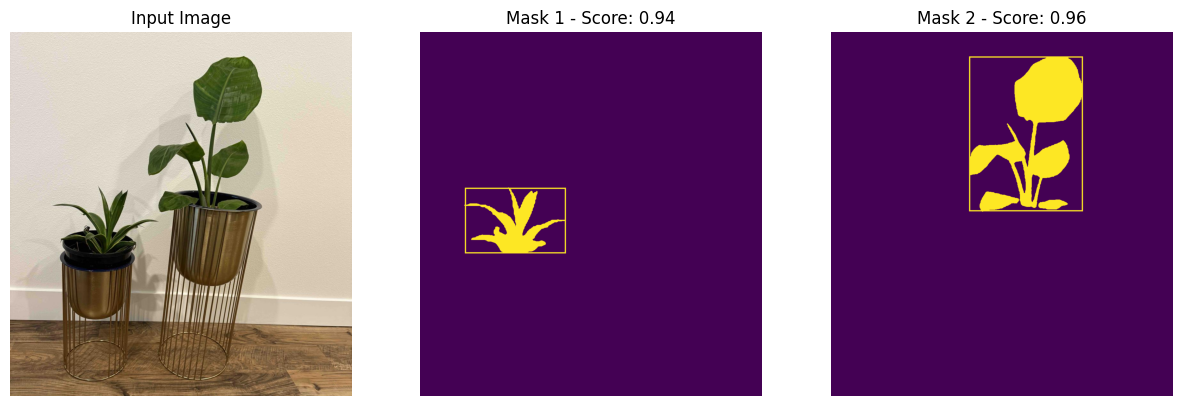

In [18]:
fig, axes = plt.subplots(1, len(results['masks']) + 1, figsize=(len(results['masks']) * 5 + 5, 5), dpi=100)
axes[0].imshow(image)
axes[0].set_title("Input Image")
axes[0].axis("off")
for i, mask in enumerate(results['masks']):
    mask = Image.fromarray((mask.cpu().numpy() * 255).astype("uint8"))
    # draw bounding box on mask
    draw = ImageDraw.Draw(mask)
    draw.rectangle(results['boxes'][i].cpu().numpy().tolist(), outline="white", width=4)

    
    axes[i + 1].imshow(mask)
    axes[i + 1].set_title(f"Mask {i + 1} - Score: {results['scores'][i]:.2f}")
    axes[i + 1].axis("off")
plt.show()